In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Der ganze Monai shit
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

# PyTorch und PyTorch Lighning
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint

# Weiteres
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from torchsummary import summary # Größe des Netzes anzeigen

# eigenes Python File (PT_Dataset.py) zum Daten laden 
from pt_dataset import TorchDataset #*******************************************************************************

print_config()

MONAI version: 0.6.0
Numpy version: 1.20.2
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.2.0
Tensorboard version: 2.2.0
gdown version: 3.10.1
TorchVision version: 0.2.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.1
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# FESTLEGEN

# ACHTUNG: UNet mit strides=(2, 2, 2, 2): 2*2*2*2=16 -> x,y,z der Bilder muss durch 16 teilbar sein!!!!!!!!!!!

# Ordner wo die Ergebnisse gespeichert werden
root_dir = "/home/wolfda/Clinic_Data/Data/Leber/Networks"
print(root_dir)

# Daten Train / Val  [für beide: .pt file, "vol": Bild, "class": lable]
train = "/home/wolfda/Clinic_Data/Data/Leber/Python_net/48_64_64/train"
val = "/home/wolfda/Clinic_Data/Data/Leber/Python_net/48_64_64/val"

# TORCH DATASET: unsqueeze(0) ja (Weil Daten ohen abgespeichert) | .float() ja (Weil Daten ohen abgespeichert)

# Festlegen
Model = "A"  # NEUES MODEL: zählen A,B;C,..
Versuch = "0" # NEUER VERSUCH: nummerieren 0,1,2,3 (alle versuche eines Models erschinen zusammen um tb)
# Speicherort Model: save - model*[A,B,C,..] - Versuch*[0,1,2,...]_epoch* - last.ckpt || TB logs: save - model*[A,B,C,..] - logs - default - version*[0,1,2,...]
network = "Unet"
Epochen = 90 # Wieviele Epochen 
lr = 1e-3 # Learning rate
db = 0.3 # Dropout prob[0-1]
train_bs = 2 # Batch Size Training
optim = "Adam" # Optimizer 

print("Model:", Model, "| Versuch:", Versuch, "| Netz:", network, "| Epochen:", Epochen, "| Learning Rate:", lr, "| Dropout Prob:", db, "| Train Bs:", train_bs,"| Optimizer:", optim)

info={"Path": root_dir, "Train": train, "Model": Model, "Versuch": Versuch, "Network": network, "Epochen": Epochen, "Learning Rate": lr, "Dropout Prob": db, "Train Bs": train_bs, "Optimizer": optim}

/home/wolfda/Clinic_Data/Data/Leber/Networks
Model: A | Versuch: 0 | Netz: Unet | Epochen: 90 | Learning Rate: 0.001 | Dropout Prob: 0.3 | Train Bs: 2 | Optimizer: Adam


In [3]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            dimensions=3, # 3D 
            in_channels=1, # Anzahl Channel In
            out_channels=1, # Anzahl Channel Out
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
        self.post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        
        summary(self._model, input_size=(1, 1, 56, 802, 802))

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        
        set_determinism(seed=0)

        # Erstellt Dataset (Pfad in dem alle Bilder + lable liegen ([vol, class]) übergeben)
        self.train_ds = TorchDataset(train, augmentations=False) # (PT_Dataset.py) ************************************************
        self.val_ds = TorchDataset(val, augmentations=False)
        print("Train Data Size", len(self.train_ds))
  

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=train_bs, shuffle=True,
            num_workers=10, collate_fn=list_data_collate,
        )
        print("Train Data Loader | Bs:", train_bs, "| len",  len(train_loader))
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=10)
        print("Val Data Loader", len(val_loader))
        return val_loader
    
    def test_dataloader(self): # self.val_ds wenn man wirklich testen will
        test_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=10)
        return test_loader

    def configure_optimizers(self):
        if optim == "Adam":
            optimizer = torch.optim.Adam(self._model.parameters(), lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch # [bs, 1, 48, 64, 64], [bs, 1, 48, 64, 64] 
        print("Training", images.shape, labels.shape)
        
        output = self.forward(images)# [bs, 4] (bs, classes = 4)
        #print("Train Outputs", output)
        #print("Train Labels", labels)
        
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        
        return {"loss": loss, "log": tensorboard_logs}
    
    def training_epoch_end(self, outputs): # outputs = Elemente im train Dataset  x {"loss": loss, "log": tensorboard_logs}
        #print("All Train Losses", outputs)
        train_loss, num_items = 0, 0
        
        for output in outputs: # Durchläuft alle elemete im train Dataset 
            #print("Nummer:", num_items)
            
            #print("Train Loss", output["loss"].sum().item())
            train_loss += output["loss"].sum().item() # Alle Losse aufaddieren 
            num_items += 1
            
        mean_train_loss = torch.tensor(train_loss / num_items) # mittlerer Loss
        print("Train Loss Mean", mean_train_loss)
        
        tensorboard_logs = {
            "training_loss": mean_train_loss,
        }
        
        return {"log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch # [1, 1, 48, 64, 64], [1, 1, 48, 64, 64]  
        #print("Val", images.shape, labels.shape)
        
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        print(loss)
        return {"val_loss": loss, "val_number": len(outputs)}

    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        images, labels = batch # [bs, 1, 48, 64, 64], [bs, 1, 48, 64, 64] 
        #print("Val", images.shape, labels.shape)
        
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        print(loss)
        return {"test_loss": loss, "test_number": len(outputs)}

    def test_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        
        for output in outputs:
            val_loss += output["test_loss"].sum().item()
            num_items += output["test_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "test_dice": mean_val_dice,
            "test_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [4]:
# initialise the LightningModule
net = Net()

# Pfad zum Speichern: 
log_dir = os.path.join(root_dir, "save", "model_" + Model, "logs") # tensorboard logs
checkpoint_dir = os.path.join(root_dir, "save", "model_" + Model, "versuch_" + Versuch) # model 

# tensorboard loggers speichern
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

# Netz speichern 
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(
        log_dir, "{epoch}-{val_loss:.2f}-{val_dice:.2f}")
)

# Netz speichern 
checkpoint_callback = ModelCheckpoint( #  macht jedes mal ein neuen Ordner auf (logs-"test1-{epoch}-{val_loss:.2f}") speichert Stand des letzten Trainingsschritts
    filepath=os.path.join(checkpoint_dir, "{epoch}-{val_loss:.2f}"), # Speicher Pfad **2
    save_last = True, # Speichert den Stand der letzten Epoche des Trainings (Name: last.ckpt)
    save_top_k=2, # Speichert den Stand der k=2 besten Epochen [bester val loss] des Trainings (Name: epoch=*-val_loss=*.ckpt)
)

# Info Speichern
torch.save(info, checkpoint_dir + "/info.pt")


# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[-1],
    max_epochs=Epochen, # Epochen
    logger=tb_logger, # tensorboard loggers speichern
    checkpoint_callback=checkpoint_callback, # Model checkpoints speichern
    num_sanity_val_steps=1,
)

# Info über das Netz
#print(summary(net))

# train
trainer.fit(net)

# test
trainer.test(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ResidualUnit: 2-1                      --
|    |    └─Sequential: 3-1                   7,442
|    |    └─Conv3d: 3-2                       448
|    └─SkipConnection: 2-2                    --
|    |    └─Sequential: 3-3                   4,799,182
|    └─Sequential: 2-3                        --
|    |    └─Convolution: 3-4                  868
|    |    └─ResidualUnit: 3-5                 28
Total params: 4,807,968
Trainable params: 4,807,968
Non-trainable params: 0
Train Data Size 8


/home/wolfda/anaconda3/envs/Monai/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4 M   
1 | loss_function | DiceLoss | 0     


Val Data Loader 2


Validation sanity check: 0it [00:00, ?it/s]

tensor(1.5162, device='cuda:0')
current epoch: 0 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Data Loader | Bs: 2 | len 4
Val Data Loader 2


/home/wolfda/anaconda3/envs/Monai/lib/python3.9/site-packages/monai/losses/dice.py:121: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/home/wolfda/anaconda3/envs/Monai/lib/python3.9/site-packages/monai/losses/dice.py:130: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

tensor(1.9531, device='cuda:0')
tensor(1.6508, device='cuda:0')
current epoch: 0 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4779)


Validating: 0it [00:00, ?it/s]

tensor(0.8972, device='cuda:0')
tensor(0.8555, device='cuda:0')
current epoch: 1 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.1465)


Validating: 0it [00:00, ?it/s]

tensor(0.6486, device='cuda:0')
tensor(0.6155, device='cuda:0')
current epoch: 2 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.3962)


Validating: 0it [00:00, ?it/s]

tensor(0.5954, device='cuda:0')
tensor(0.5901, device='cuda:0')
current epoch: 3 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4898)


Validating: 0it [00:00, ?it/s]

tensor(1.2865, device='cuda:0')
tensor(0.5101, device='cuda:0')
current epoch: 4 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.2650)


Validating: 0it [00:00, ?it/s]

tensor(0.6724, device='cuda:0')
tensor(0.4858, device='cuda:0')
current epoch: 5 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(1.2481)


Validating: 0it [00:00, ?it/s]

tensor(0.8984, device='cuda:0')
tensor(0.6379, device='cuda:0')
current epoch: 6 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-2.4229)


Validating: 0it [00:00, ?it/s]

tensor(0.8337, device='cuda:0')
tensor(0.5695, device='cuda:0')
current epoch: 7 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-1.4888)


Validating: 0it [00:00, ?it/s]

tensor(0.6874, device='cuda:0')
tensor(0.4067, device='cuda:0')
current epoch: 8 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6984)


Validating: 0it [00:00, ?it/s]

tensor(0.6506, device='cuda:0')
tensor(0.3085, device='cuda:0')
current epoch: 9 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6665)


Validating: 0it [00:00, ?it/s]

tensor(0.6358, device='cuda:0')
tensor(0.2678, device='cuda:0')
current epoch: 10 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(1.0552)


Validating: 0it [00:00, ?it/s]

tensor(0.6433, device='cuda:0')
tensor(0.2688, device='cuda:0')
current epoch: 11 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(1.2234)


Validating: 0it [00:00, ?it/s]

tensor(0.6480, device='cuda:0')
tensor(0.2730, device='cuda:0')
current epoch: 12 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(1.0108)


Validating: 0it [00:00, ?it/s]

tensor(0.6499, device='cuda:0')
tensor(0.2724, device='cuda:0')
current epoch: 13 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8975)


Validating: 0it [00:00, ?it/s]

tensor(0.6605, device='cuda:0')
tensor(0.2878, device='cuda:0')
current epoch: 14 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.9155)


Validating: 0it [00:00, ?it/s]

tensor(0.6725, device='cuda:0')
tensor(0.3047, device='cuda:0')
current epoch: 15 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8949)


Validating: 0it [00:00, ?it/s]

tensor(0.6795, device='cuda:0')
tensor(0.3173, device='cuda:0')
current epoch: 16 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8819)


Validating: 0it [00:00, ?it/s]

tensor(0.6877, device='cuda:0')
tensor(0.3306, device='cuda:0')
current epoch: 17 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8680)


Validating: 0it [00:00, ?it/s]

tensor(0.6948, device='cuda:0')
tensor(0.3416, device='cuda:0')
current epoch: 18 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8628)


Validating: 0it [00:00, ?it/s]

tensor(0.6904, device='cuda:0')
tensor(0.3416, device='cuda:0')
current epoch: 19 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8585)


Validating: 0it [00:00, ?it/s]

tensor(0.6986, device='cuda:0')
tensor(0.3509, device='cuda:0')
current epoch: 20 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8511)


Validating: 0it [00:00, ?it/s]

tensor(0.7067, device='cuda:0')
tensor(0.3620, device='cuda:0')
current epoch: 21 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8418)


Validating: 0it [00:00, ?it/s]

tensor(0.7064, device='cuda:0')
tensor(0.3638, device='cuda:0')
current epoch: 22 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8584)


Validating: 0it [00:00, ?it/s]

tensor(0.7081, device='cuda:0')
tensor(0.3671, device='cuda:0')
current epoch: 23 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8157)


Validating: 0it [00:00, ?it/s]

tensor(0.7108, device='cuda:0')
tensor(0.3724, device='cuda:0')
current epoch: 24 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8366)


Validating: 0it [00:00, ?it/s]

tensor(0.7108, device='cuda:0')
tensor(0.3694, device='cuda:0')
current epoch: 25 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8243)


Validating: 0it [00:00, ?it/s]

tensor(0.7138, device='cuda:0')
tensor(0.3728, device='cuda:0')
current epoch: 26 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8441)


Validating: 0it [00:00, ?it/s]

tensor(0.7169, device='cuda:0')
tensor(0.3772, device='cuda:0')
current epoch: 27 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8253)


Validating: 0it [00:00, ?it/s]

tensor(0.7195, device='cuda:0')
tensor(0.3782, device='cuda:0')
current epoch: 28 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8082)


Validating: 0it [00:00, ?it/s]

tensor(0.7204, device='cuda:0')
tensor(0.3826, device='cuda:0')
current epoch: 29 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8033)


Validating: 0it [00:00, ?it/s]

tensor(0.7221, device='cuda:0')
tensor(0.3864, device='cuda:0')
current epoch: 30 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7983)


Validating: 0it [00:00, ?it/s]

tensor(0.7258, device='cuda:0')
tensor(0.3903, device='cuda:0')
current epoch: 31 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8006)


Validating: 0it [00:00, ?it/s]

tensor(0.7240, device='cuda:0')
tensor(0.3930, device='cuda:0')
current epoch: 32 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8053)


Validating: 0it [00:00, ?it/s]

tensor(0.7280, device='cuda:0')
tensor(0.3956, device='cuda:0')
current epoch: 33 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.8190)


Validating: 0it [00:00, ?it/s]

tensor(0.7304, device='cuda:0')
tensor(0.3976, device='cuda:0')
current epoch: 34 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7957)


Validating: 0it [00:00, ?it/s]

tensor(0.7330, device='cuda:0')
tensor(0.4020, device='cuda:0')
current epoch: 35 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7880)


Validating: 0it [00:00, ?it/s]

tensor(0.7339, device='cuda:0')
tensor(0.4021, device='cuda:0')
current epoch: 36 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7870)


Validating: 0it [00:00, ?it/s]

tensor(0.7328, device='cuda:0')
tensor(0.4047, device='cuda:0')
current epoch: 37 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7867)


Validating: 0it [00:00, ?it/s]

tensor(0.7347, device='cuda:0')
tensor(0.4036, device='cuda:0')
current epoch: 38 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7758)


Validating: 0it [00:00, ?it/s]

tensor(0.7357, device='cuda:0')
tensor(0.4019, device='cuda:0')
current epoch: 39 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7667)


Validating: 0it [00:00, ?it/s]

tensor(0.7387, device='cuda:0')
tensor(0.4058, device='cuda:0')
current epoch: 40 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7548)


Validating: 0it [00:00, ?it/s]

tensor(0.7396, device='cuda:0')
tensor(0.4064, device='cuda:0')
current epoch: 41 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7751)


Validating: 0it [00:00, ?it/s]

tensor(0.7399, device='cuda:0')
tensor(0.4086, device='cuda:0')
current epoch: 42 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7567)


Validating: 0it [00:00, ?it/s]

tensor(0.7439, device='cuda:0')
tensor(0.4146, device='cuda:0')
current epoch: 43 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7248)


Validating: 0it [00:00, ?it/s]

tensor(0.7422, device='cuda:0')
tensor(0.4123, device='cuda:0')
current epoch: 44 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7720)


Validating: 0it [00:00, ?it/s]

tensor(0.7382, device='cuda:0')
tensor(0.4075, device='cuda:0')
current epoch: 45 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7555)


Validating: 0it [00:00, ?it/s]

tensor(0.7433, device='cuda:0')
tensor(0.4129, device='cuda:0')
current epoch: 46 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7231)


Validating: 0it [00:00, ?it/s]

tensor(0.7416, device='cuda:0')
tensor(0.4140, device='cuda:0')
current epoch: 47 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7434)


Validating: 0it [00:00, ?it/s]

tensor(0.7450, device='cuda:0')
tensor(0.4184, device='cuda:0')
current epoch: 48 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7071)


Validating: 0it [00:00, ?it/s]

tensor(0.7480, device='cuda:0')
tensor(0.4200, device='cuda:0')
current epoch: 49 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7094)


Validating: 0it [00:00, ?it/s]

tensor(0.7501, device='cuda:0')
tensor(0.4214, device='cuda:0')
current epoch: 50 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7141)


Validating: 0it [00:00, ?it/s]

tensor(0.7494, device='cuda:0')
tensor(0.4186, device='cuda:0')
current epoch: 51 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7092)


Validating: 0it [00:00, ?it/s]

tensor(0.7504, device='cuda:0')
tensor(0.4237, device='cuda:0')
current epoch: 52 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6929)


Validating: 0it [00:00, ?it/s]

tensor(0.7509, device='cuda:0')
tensor(0.4247, device='cuda:0')
current epoch: 53 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6578)


Validating: 0it [00:00, ?it/s]

tensor(0.7534, device='cuda:0')
tensor(0.4290, device='cuda:0')
current epoch: 54 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6986)


Validating: 0it [00:00, ?it/s]

tensor(0.7497, device='cuda:0')
tensor(0.4255, device='cuda:0')
current epoch: 55 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7002)


Validating: 0it [00:00, ?it/s]

tensor(0.7506, device='cuda:0')
tensor(0.4272, device='cuda:0')
current epoch: 56 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6893)


Validating: 0it [00:00, ?it/s]

tensor(0.7478, device='cuda:0')
tensor(0.4257, device='cuda:0')
current epoch: 57 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6693)


Validating: 0it [00:00, ?it/s]

tensor(0.7514, device='cuda:0')
tensor(0.4335, device='cuda:0')
current epoch: 58 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6215)


Validating: 0it [00:00, ?it/s]

tensor(0.7550, device='cuda:0')
tensor(0.4440, device='cuda:0')
current epoch: 59 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6276)


Validating: 0it [00:00, ?it/s]

tensor(0.7562, device='cuda:0')
tensor(0.4472, device='cuda:0')
current epoch: 60 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6183)


Validating: 0it [00:00, ?it/s]

tensor(0.7487, device='cuda:0')
tensor(0.4411, device='cuda:0')
current epoch: 61 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.6147)


Validating: 0it [00:00, ?it/s]

tensor(0.7524, device='cuda:0')
tensor(0.4535, device='cuda:0')
current epoch: 62 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.5640)


Validating: 0it [00:00, ?it/s]

tensor(0.7548, device='cuda:0')
tensor(0.4614, device='cuda:0')
current epoch: 63 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.5696)


Validating: 0it [00:00, ?it/s]

tensor(0.7495, device='cuda:0')
tensor(0.4635, device='cuda:0')
current epoch: 64 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.5577)


Validating: 0it [00:00, ?it/s]

tensor(0.7395, device='cuda:0')
tensor(0.4518, device='cuda:0')
current epoch: 65 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.5436)


Validating: 0it [00:00, ?it/s]

tensor(0.7376, device='cuda:0')
tensor(0.4572, device='cuda:0')
current epoch: 66 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.5195)


Validating: 0it [00:00, ?it/s]

tensor(0.7427, device='cuda:0')
tensor(0.4815, device='cuda:0')
current epoch: 67 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4942)


Validating: 0it [00:00, ?it/s]

tensor(0.7504, device='cuda:0')
tensor(0.5102, device='cuda:0')
current epoch: 68 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4798)


Validating: 0it [00:00, ?it/s]

tensor(0.7607, device='cuda:0')
tensor(0.5465, device='cuda:0')
current epoch: 69 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4479)


Validating: 0it [00:00, ?it/s]

tensor(0.7795, device='cuda:0')
tensor(0.5985, device='cuda:0')
current epoch: 70 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4427)


Validating: 0it [00:00, ?it/s]

tensor(0.7890, device='cuda:0')
tensor(0.6319, device='cuda:0')
current epoch: 71 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.4006)


Validating: 0it [00:00, ?it/s]

tensor(0.7945, device='cuda:0')
tensor(0.6633, device='cuda:0')
current epoch: 72 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.3843)


Validating: 0it [00:00, ?it/s]

tensor(0.7799, device='cuda:0')
tensor(0.6634, device='cuda:0')
current epoch: 73 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.3249)


Validating: 0it [00:00, ?it/s]

tensor(0.7746, device='cuda:0')
tensor(0.6793, device='cuda:0')
current epoch: 74 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.2457)


Validating: 0it [00:00, ?it/s]

tensor(0.7789, device='cuda:0')
tensor(0.7169, device='cuda:0')
current epoch: 75 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.2319)


Validating: 0it [00:00, ?it/s]

tensor(0.7673, device='cuda:0')
tensor(0.7294, device='cuda:0')
current epoch: 76 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.1803)


Validating: 0it [00:00, ?it/s]

tensor(0.7462, device='cuda:0')
tensor(0.7212, device='cuda:0')
current epoch: 77 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.1710)


Validating: 0it [00:00, ?it/s]

tensor(0.7118, device='cuda:0')
tensor(0.6769, device='cuda:0')
current epoch: 78 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.1472)


Validating: 0it [00:00, ?it/s]

tensor(0.7382, device='cuda:0')
tensor(0.7583, device='cuda:0')
current epoch: 79 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.0768)


Validating: 0it [00:00, ?it/s]

tensor(0.7629, device='cuda:0')
tensor(0.8213, device='cuda:0')
current epoch: 80 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.0269)


Validating: 0it [00:00, ?it/s]

tensor(0.7746, device='cuda:0')
tensor(0.8548, device='cuda:0')
current epoch: 81 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.0312)


Validating: 0it [00:00, ?it/s]

tensor(0.7711, device='cuda:0')
tensor(0.8560, device='cuda:0')
current epoch: 82 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.0794)


Validating: 0it [00:00, ?it/s]

tensor(0.6568, device='cuda:0')
tensor(0.5900, device='cuda:0')
current epoch: 83 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.9222)


Validating: 0it [00:00, ?it/s]

tensor(0.5475, device='cuda:0')
tensor(0.3042, device='cuda:0')
current epoch: 84 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(-0.0819)


Validating: 0it [00:00, ?it/s]

tensor(0.4964, device='cuda:0')
tensor(0.1165, device='cuda:0')
current epoch: 85 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.0763)


Validating: 0it [00:00, ?it/s]

tensor(0.5471, device='cuda:0')
tensor(0.1554, device='cuda:0')
current epoch: 86 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.9456)


Validating: 0it [00:00, ?it/s]

tensor(0.6770, device='cuda:0')
tensor(0.3118, device='cuda:0')
current epoch: 87 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7765)


Validating: 0it [00:00, ?it/s]

tensor(0.7932, device='cuda:0')
tensor(0.4750, device='cuda:0')
current epoch: 88 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
Train Loss Mean tensor(0.7942)


Validating: 0it [00:00, ?it/s]

tensor(0.8678, device='cuda:0')
tensor(0.5962, device='cuda:0')
current epoch: 89 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0


Saving latest checkpoint..


Train Loss Mean tensor(0.7641)
Train Data Size 8


Testing: 0it [00:00, ?it/s]

tensor(0.8678, device='cuda:0')
tensor(0.5962, device='cuda:0')
current epoch: 89 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 0
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_dice': 0.0, 'test_loss': tensor(0.7320)}
--------------------------------------------------------------------------------


[{'test_dice': 0.0, 'test_loss': 0.7319929599761963}]

In [6]:
%load_ext tensorboard
%tensorboard --logdir="/home/wolfda/Clinic_Data/Data/Leber/Networks/save/model_A/logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Val Data Loader 2


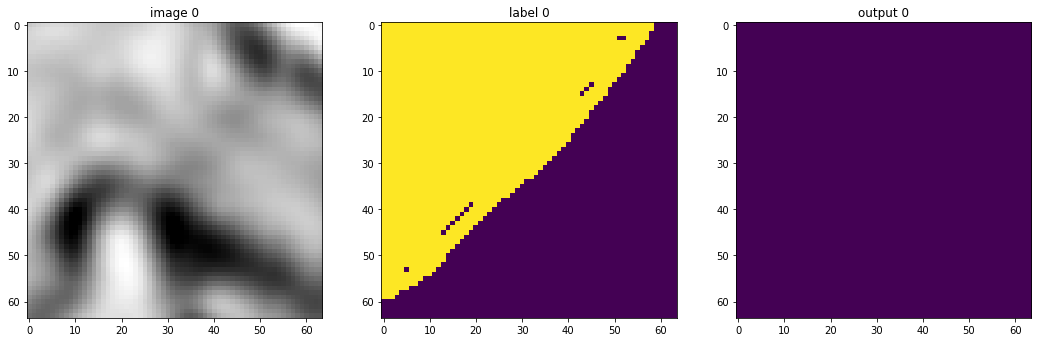

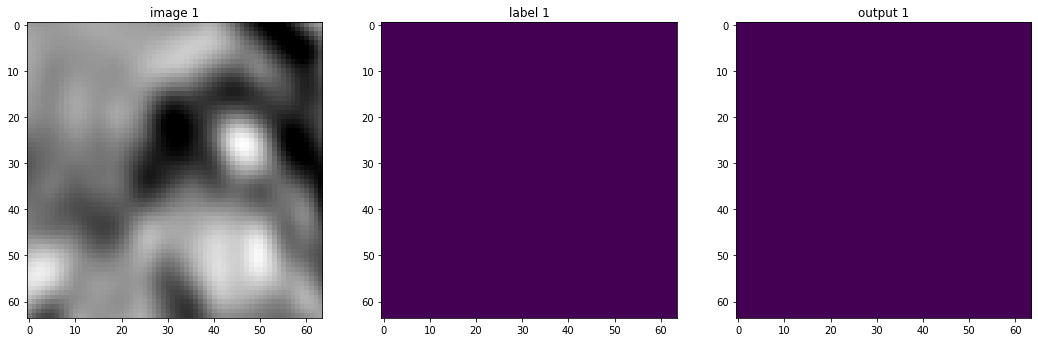

In [23]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
   
    for i, data in enumerate(net.val_dataloader()):
        roi_size = (48, 64, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            data[0].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 63]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(data[0][0, 0, 20, :, :], cmap="gray") # Größe Anpassen
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(data[1][0, 0, 20, :, :]) # Größe anpassen
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, 20, :, :]) # Größe anpassen
        plt.show()